In [1]:
#!pip install tensorflow scikit-learn

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [4]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.3.0


### 과제 1

##### 강의 중 배운 내용 몇가지를 직접 구현해보자!

1. Weight initialization 
  * Xavier initialization을 직접 구현해보세요. [모르겠다면 참조](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)


##### 도전 정신이 뛰어나신 분들을 위한 과제... (안해도 됩니다)

2. Regularizer (선택)
    * Regularizer를 직접 구현해보세요. 역전파를 위한 regularization이니 이 점 꼭 기억하세요 [참조](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

3. Activation (선택)
    * 활성화 함수를 직접 구현해보세요. 활성화 함수에 따라서 gradient backpropagation 방식이 달라집니다. 활성화 함수를 추가한다면 gradient를 구하는 공식도 활성화 함수에 맞게 구현해야 합니다.
    

In [5]:
# data
(train_X, train_y) , (test_X, test_y) = tf.keras.datasets.fashion_mnist.load_data()

# MLP를 위한 shape 조정
train_X, test_X = train_X.reshape((-1, 28*28)), test_X.reshape((-1,28*28))

# 원활한 학습을 위한 scaling
train_X = MinMaxScaler().fit_transform(train_X)

train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [6]:
class mlp():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.classes = len(set(self.y))
        
        # weight initialization (random initialization from normal distribution)
        self.W = self.initialize(self.X.shape[1],self.classes)
        self.b = np.zeros((1,self.classes))
                
        # your code goes here
        
    def regularizer(self,A):
        # your code goes here
        # (example given is l2 regularization)
        return self.reg*A                    #L2 Regularization for backward prop
    
    def initialize(self,m,h):
        sd = np.sqrt(2/(m+h))
        init = np.random.normal(scale=sd,size=(m,h))  #Xavier initialization
        return init
    
    def activation(self, A):
        Activation = np.maximum(A,0)
        return Activation                             #Relu activation
    
    def softmax(self, A):
        return np.exp(A) / np.exp(A).sum()
    
    def feedForward(self, X):
        # 아래는 softmax를 axis=1(주어진 batch에서 각 데이터별로) softmax를 취하는 함수 입니다.
        return np.apply_along_axis(self.softmax, -1, self.activation(np.matmul(X, self.W) + self.b))
    
    def train(self, lr, iteration, batch_size, reg=0.01):
        self.lr = lr
        self.reg = reg
        self.batch_size = batch_size
        self.loss_hist = []
        self.W_hist = []
        self.b_hist = []
        
        for epoch in range(iteration):
            print(f"Epoch {epoch + 1}")
            loss, W, b = self.gd()
            print(f"Loss : {loss[-1]}")
            self.loss_hist.extend(loss)
            self.W_hist.extend(W)
            self.b_hist.extend(b)
            
        self.param = (self.W_hist[-1], self.b_hist[-1])
        self.losses = (self.loss_hist[-1])
        return self.param, self.losses
    
    def gd(self):
        loss_list = []
        W_list = []
        b_list = []
        
        x_batches = np.split(self.X, len(self.X)/self.batch_size)
        y_batches = np.split(self.y, len(self.X)/self.batch_size)
        
        for inp, tar in zip(x_batches,y_batches):
            y_hat = self.feedForward(inp)
            self.loss = (-np.log(y_hat[np.eye(10)[tar].astype(bool)])).mean() + np.sum(np.matmul(self.W.T,self.W))*self.reg/(2*len(x_batches))
            loss_list.append(self.loss)
            
            # softmax classifier의 gradient 함수
            self.gradient = (y_hat - np.eye(10)[tar]) / tar.shape[0]
            
            # backpropagation for Weights
            A = np.matmul(inp, self.W) + self.b
            mask = (A<=0)
            self.gradient[mask] = 0
            dZ = self.gradient
            dW = np.dot(inp.T, dZ) + self.regularizer(self.W)/len(x_batches)
            self.W -= self.lr*(dW)
            W_list.append(self.W)
            
            # backpropagation for biases
            db = dZ.sum(axis=0, keepdims=True)
            self.b -= self.lr*(db)
            b_list.append(self.b)
            
        return loss_list, W_list, b_list
    
    def evaluate(self, X):
        return self.feedForward(X)
    
    def get_params(self):
        return self.param

In [10]:
model = mlp(train_X, train_y)

In [11]:
(W, b), loss = model.train(lr=0.01, iteration=5, batch_size=60)

Epoch 1
Loss : 0.9888496177527922
Epoch 2
Loss : 0.9061925482471516
Epoch 3
Loss : 0.8689808540789494
Epoch 4
Loss : 0.8455180798359437
Epoch 5
Loss : 0.8285605944084521


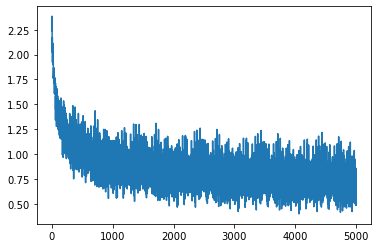

In [12]:
plt.plot(model.loss_hist)
plt.show()

### 과제 2

##### tensorflow를 활용해서 MLP모델을 편하게 설계 해보자!

1. 데이터 선택
    * 모델링 해보고 싶은 데이터 선택
    * 데이터를 활용해 간단한 EDA를 실행해보시길 권장드립니다
2. MLP 설계
    * 원하는 구조로 MLP 모델 설계
3. 성능 확인 및 parameter 조정
    * 성능을 확인하고, 성능개선을 위해 parameter 조정
    * 고려해볼 parameter 조정 : 
        * Number of layers
        * Number of hidden units
        * Activation function
        * Batch Size
        * Training Epochs 
        * etc.

#### 간단한 데이터 설명
- Boston Housing 데이터: 
    * 13개의 연속형 변수 항목으로 해당 지역의 집값 (중위값)을 구하는 TASK
- MNIST 데이터:
    * 28 X 28의 픽셀 값으로 구성되어 있으며 해당 그림이 어느 숫자인지 분류하는 TASK
- CIFAR 10 데이터:
    * 32 X 32 X 3의 픽셀 값으로 구성되어 있으며 10가지의 항목 중 어느 항목에 해당하는 사진인지 분류하는 TASK
- 도전해보고 싶은 데이터 외부에서 가져와도 됩니다!

*데이터에 대해 더 자세히 알고 싶다면 https://keras.io/api/datasets/ 참조*

#### 몇가지 가이드라인 코드입니다

In [13]:
# MLP모델의 학습 과정을 시각화를 위한 함수
def plot_history(history):
    plt.figure(figsize = (10,10))
    for e, (item, value) in enumerate(history.history.items()):
        plt.subplot(2,2,e+1)
        plt.plot(value)
        plt.title(item)
    plt.show()
    
# 사용법
# history = model.fit(...)
# plot_history(history)

In [14]:
# tensorflow parameters

activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

### 데이터 선택

In [37]:
### MNIST 분류
(train_X, train_y) , (test_X, test_y) = tf.keras.datasets.mnist.load_data()
train_X, test_X = train_X.reshape((-1, 28*28)), test_X.reshape((-1, 28*28))
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

### EDA (권장) 

* 필요에 따른 EDA를 실시하세요 ! :)

In [38]:
train_X = train_X/255
train_y = np.eye(10)[train_y]
test_X = test_X/255
test_y = np.eye(10)[test_y]
train_y.shape, test_y.shape

((60000, 10), (10000, 10))

## 모델링

* 다양하게 시도해보세요! :) 